# Artifact 3: Shortest Path Problem

In this artifact, we'll setup (and simulate) the shortest path problem using linear programming, and verify it's results with Networkx' `shortest_path()` function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.optimize import linprog
from scipy.spatial.distance import euclidean

In [2]:
nodes = pd.read_csv("stations.csv",index_col=0)

In [3]:
nodes.head()

,name,x,y
index,,,
0,Downtown,-123.121405,49.280311
1,HastingsClark,-123.077084,49.281288
2,BoundaryHastings,-123.023351,49.281132
3,MainTerminal,-123.099939,49.272719
4,Clark1st,-123.077314,49.269678


In [4]:
edges = pd.read_csv("routes.csv")

In [5]:
edges.head()

,from,to
0,5,2
1,5,4
2,5,12
3,2,5
4,2,1


In [6]:
G = nx.DiGraph()

In [7]:
G.add_nodes_from(nodes.index)

In [8]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24))

In [9]:
for i in edges.index:
    source = edges.iloc[i,0]
    target = edges.iloc[i,1]
    G.add_edge(source,target,capacity=10)

In [10]:
coordinates = []
for i in nodes.index:
    x = nodes.iloc[i,1]
    y = nodes.iloc[i,2]
    coordinates.append((x,y))

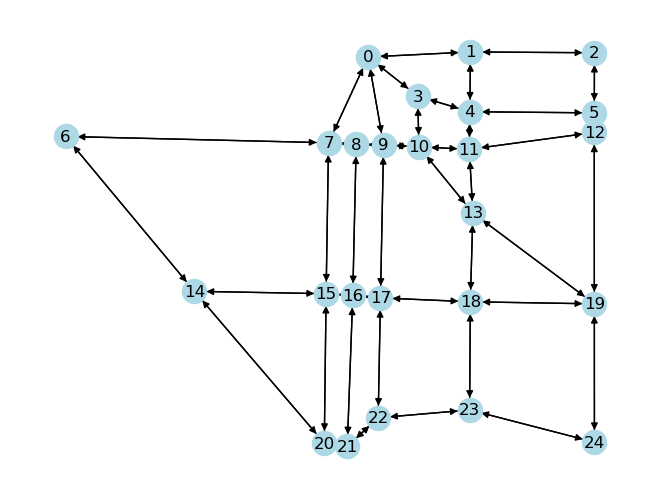

In [11]:
nx.draw(G,pos=coordinates,
        with_labels=True,
        node_color='lightblue')

### Calculate Shortest Path using scipy.optimize.linprog

In [12]:
edges['from'] = edges['from'].astype(int)
edges['to'] = edges['to'].astype(int)

To find the shortest path between a source node and a target node, we need to assign costs or weights to our edges for the objective function to minimize. Since we already have coordinates of each nodes in our dataset, lets calculate the euclidean distances for each edge. This intuitively makes sense, since our LP model will essentially find the shortest distance or "path" between a source node and a target node.

In [13]:
edges['cost'] = edges.apply(lambda row: euclidean(nodes.loc[row['from'], ['x', 'y']], 
                                                  nodes.loc[row['to'], ['x', 'y']]), axis=1)

In [14]:
# The number of decision variables is equal to the number of edges
num_edges = len(edges)

In [15]:
# Objective function: minimize the total cost of the path
c = edges['cost'].to_numpy()

Now let's setup constraints for our LP model. For each node, the sum of the decision variables for edges entering the node minus the sum of the decision variables for edges leaving the node should be 0 (except for the source and target nodes)

Why is that? In the context of the shortest path, the decision variables represent whether an edge is included in the path (1) or not (0). For any node that is not the source or the destination, the number of paths entering the node must be equal to the number of paths leaving it. This ensures that the node is not the starting point or ending point of a path but a transit point. Here's what the constraints mean:

- **For the source node**: There should be one more edge leaving than entering because the path starts here. This is represented by a net flow of 1.

- **For the target (sink) node**: There should be one more edge entering than leaving because the path ends here. This is represented by a net flow of -1.

- **For all other nodes**: The number of edges entering any node must be the same as the number of edges leaving if the node is part of the path. This ensures that the path is continuous and does not terminate prematurely or branch off. This is represented by a net flow of 0.

Through our understanding of the objective function and constraints, we model the LP model in the following manner:

Minimize the objective function:  

$$
c^T \cdot x
$$

subject to the constraints:  

$$
A_{eq} \cdot x = b_{eq}
$$

with bounds:  

$$
l \

Here, $ A_{eq} $ is a 2x2 matrix and $ b_{eq} $ is a 2x1 matrix. eq x \leq u
$$


In [16]:
A_eq = np.zeros((len(nodes), num_edges))
b_eq = np.zeros(len(nodes))

In [17]:
for i, node in nodes.iterrows():
    for j, edge in edges.iterrows():
        if edge['from'] == node.name:
            A_eq[i, j] = 1
        elif edge['to'] == node.name:
            A_eq[i, j] = -1

In [18]:
# Source node (arbitrarily choosing node 0): net outflow of 1
b_eq[0] = 1

In [19]:
# Target node (arbitrarily choosing the last node): net inflow of 1
b_eq[-1] = -1

In [20]:
# Bounds for each decision variable: each can be either 0 or 1
x0_bounds = (0, 1)

In [21]:
# Solve the linear program
res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[x0_bounds]*num_edges, method='highs')

In [22]:
# Check if the optimization was successful
if res.success:
    # The optimal path is given by edges with decision variables set to 1 (or close to 1)
    path_edges = edges.iloc[np.where(res.x > 0.99)]
    print("Shortest path:", path_edges)
else:
    print("Optimization failed:", res.message)

Shortest path:     from  to      cost
24     0   3  0.022769
39    19  24  0.026865
42    10  13  0.026678
45    13  19  0.055488
60     3  10  0.009876


We see that our linprog model solves the shortest path model and outputs a result. The resulting path edges don't seem to be in a sequential order, but they seem to convey that the optimal path is 3->10->13->19->24

### Verify shortest path using `networkx.shortest_path`

There are has to be a direct and a simpler way to calculate shortest paths. Luckily, `networkx` has an in-built function, `shortest_path`, that minimizes the traversed path between a source node and a target node using Djikstra's algorithm. His algorithm utilizes a graph that has non-negative weights assigned to it's edges to do so. In our case, we have already assigned euclidean distances as costs or weights for each edge, and distances are non-negative in nature. Hence, Djikstra's algorithm can be applied to solve our problem.

In [23]:
for index, row in edges.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['cost'])

In [24]:
source_node = 0
target_node = max(nodes.index)  # Assuming the target node is the last one

In [25]:
shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')

In [26]:
# Print the shortest path and its total cost
path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))
path_costs = [G[u][v]['weight'] for u, v in path_edges]
total_cost = sum(path_costs)

print("Shortest path using NetworkX:", shortest_path)
print("Total cost:", total_cost)

Shortest path using NetworkX: [0, 3, 10, 13, 19, 24]
Total cost: 0.14167586787904146


Our linprog shortest path matches this!!

Okay this is great. Our linprog optimization works. But it's surely a bit more messy and requires a lot more steps. `networkx.shortest_path` provides an easier and faster solution. So it definitely seems a lot more preferable.

But what if we want to find the shortest path for any given set of source and target nodes? And what if we want to visualize that solution on a graph for better understanding? Let's create a function that calculates the shortest path of a given combination of source and target nodes using `networkx.shortest_path`, and helps us visualize the solution on a graph.

In [27]:
def draw_shortest_path(G, source, target, pos):
    """
    Draw the graph with the shortest path from `source` to `target` highlighted.
    
    Parameters:
    G (NetworkX graph): The graph
    source (int): The source node for the path
    target (int): The target node for the path
    pos (dict): The positions of nodes as a dictionary
    """
    
    shortest_path = nx.shortest_path(G, source=source, target=target, weight='weight')
    path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))
    non_path_edges = [edge for edge in G.edges() if edge not in path_edges and edge[::-1] not in path_edges]

    
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_edges(G, pos, edgelist=non_path_edges, alpha=0.5, width=1)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='yellow', width=2)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300)
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    plt.axis('off')
    plt.show()
    
    return shortest_path

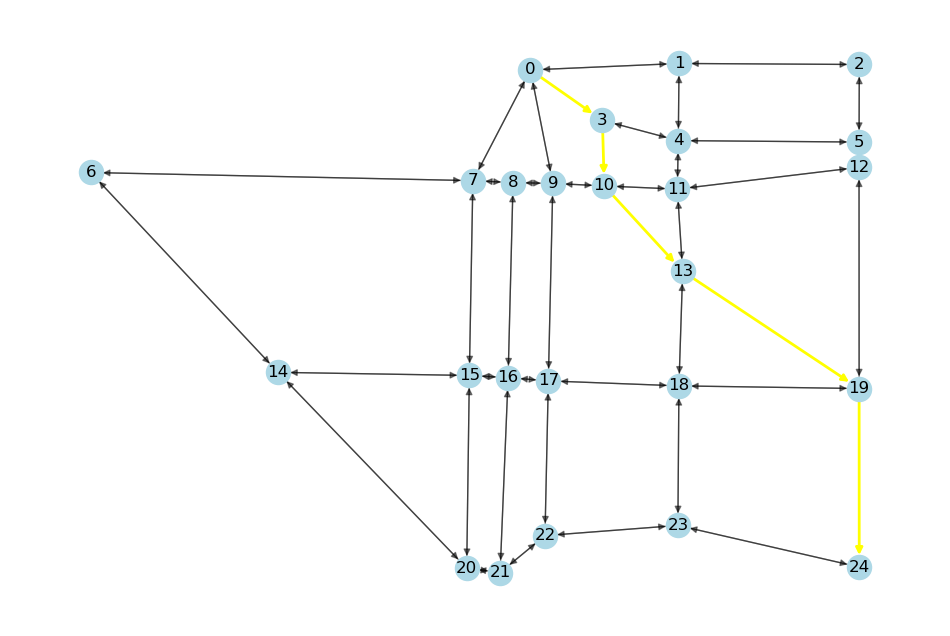

[0, 3, 10, 13, 19, 24]

In [28]:
draw_shortest_path(G, 0, 24, coordinates)

## References

- Walls, Patrick. (2024). *Vancouver Routes Dataset*. [routes.csv].  University of British Columbia.
- Walls, Patrick. (2024). *Vancouver Stations Dataset*. [stations.csv].  University of British Columbia. 

- Walls, Patrick. (2024). Class Notes from MATH 441 - Discrete Optimization. [Class Notes]. University oBritish Columbial.

- NetworkX Developers. NetworkX Reference Documentation [Software documentation]. NetworkX. [https://networkx.org/documentation/stable/reference/index.html](https://networkx.org/documentation/stable/reference/index.html)
- OpenAI. ChatGPT [Software]. Available from https://openai.com/chatgpt